## ДЗ по поиску

Привет! Вам надо реализивать поисковик на базе вопросов-ответов с сайта [pravoved.ru](https://pravoved.ru/questions-archive/).        
Поиск должен работать на трех технологиях:       
1. обратном индексе     
2. word2vec         
3. doc2vec      

Вы должны понять, какой метод и при каких условиях эксперимента на этом корпусе работает лучше.          
Для измерения качества поиска найдите точность (accuracy) выпадания правильного ответа на конкретный вопрос (в этой базе у каждого вопроса есть только один правильный ответ). Точность нужно измерить для всей базы.    
При этом давайте считать, что выпал правильный ответ, если он попал в **топ-5** поисковой выдачи.

> Сделайте ваш поиск максимально качественным, чтобы значение точности стремилось к 1.     
Для этого можно поэкспериментировать со следующим:       
- модель word2vec (можно брать любую из опен сорса или обучить свою)
- способ получения вектора документа через word2vec: простое среднее арифметическое или взвешивать каждый вектор в соответствии с его tf-idf      
- количество эпох у doc2vec (начинайте от 100)
- предобработка документов для обучения doc2vec (удалять / не удалять стоп-слова)
- блендинг методов поиска: соединить результаты обратного индекса и w2v, или (что проще) w2v и d2v

На это задание отведем 10 дней. Дэдлайн сдачи до полуночи 12.10.

In [1]:
import pickle

with open('qa_corpus.pkl', 'rb') as file:
    qa_corpus_paired = pickle.load(file)

In [2]:
qa_corpus = [doc for pair in qa_corpus_paired for doc in pair]

In [3]:
QUERIES = qa_corpus[0:2768:2]
RESPONSES = qa_corpus[1:2768:2]

Всего в корпусе 1384 пары вопрос-ответ

In [6]:
len(qa_corpus)

1384

Первый элемент блока это вопрос, второй - ответ на него

In [4]:
qa_corpus[0]

['\nДобрый день.Мой сын гражданин Украины (ДНР),имеет вид на жительство в Р.Ф., кот.получил проживая с 2014 г. в Нижегородской области.В 2017г. переехал на постоянное место жительство в г.Ростов.Официально трудоустроился на одно из промышл.предприятий г.Ростова.Оформил временную регистрацию в Ростове.В УФМС предупредили,что по истечении 90 дней он должен либо постоянно прописаться либо покинуть территорию России.Прошу проконсультировать как быть дальше.(Вернуться домой в Донецк,но здесь идет война,работы нет.В Ростове он работает по специальности.Он инженер машиностроитель.)Временная прописка до 15 марта.  Если он сможет приобрести какую либо недвижимость,как долго будет решаться вопрос о его постоянной прописке в Ростове.Как в этом случае будет решаться вопрос с видом на жительство в Ростове? Не получится ли ,что приобретя квартиру,он не успеет в ней прописаться до окончании срока временной регистрации. С уважением Людмила Евгеньевна.\n',
 'Добрый вечер!Из Вашего вопроса вообще ничего

In [4]:
import os
import re
import numpy as np
from collections import defaultdict

from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec, Doc2Vec

C:\Users\PC\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Для эффективной лемматизации я решил написать небольшое собственное API для исполняемого `MyStem.exe`, потому как доступный под windows модуль `pymystem3` работает невероятно не эффективно

Кратко:
- `MyStem.run(documents, flags, [, parse_mystem_output, pos_tags])`: исполняет `MyStem.exe` с заданными флагами `flags` для коллекции `documents`
    - `documents: List[<str>]`: коллекция документов
    - `flags: <str>`: флаги
    - `parse_mystem_output: <bool>`: привести исполненную выдачу к исходному виду коллекции (адекватный результат на наборе флагов, отличных от объявленных в коде, не гарантируется, но возможен при написании соответствующего парсера)
    - `pos_tags: <bool>`: включить POS разметку

In [5]:
class MyStem:
    
    def __init__(self, exec_path=None):
        """
        exec_path: path to mystem executable
        """
        self.EXEC_PATH = '' if exec_path is None else exec_path
    
        self.TMP_IN = 'tmp_in'
        self.TMP_OUT = 'tmp_out'
        
        self.SEP = '::SEP::'
        
    def __export_to_tmp(self, documents):
        with open(self.TMP_IN, 'w', encoding='utf-8') as tmp:
            tmp.write(self.SEP.join(documents))
            
    def __read_tmp(self):
        with open(self.TMP_OUT, 'r', encoding='utf-8') as tmp:
            return tmp.read()
        
    def __run_exec(self, flags):
        os.system('mystem %s %s %s' % (flags, self.TMP_IN, self.TMP_OUT))
    
    def __parser(self, raw_output, pos_tags):
        def parse_word_token(token):
            try:
                lemma, pos = re.split('\?=|=|\?\?', token)[:2]
            except ValueError:
                lemma = re.split('\?=|=|\?\?', token)[0]
                pos = ''
            
            lemma = re.sub('[\W]|_|u', '', lemma)
            
            if pos:
                pos = pos.split(',')[0]
            else:
                pos = 'UNKN'

            if pos_tags:
                return '%s_%s' % (lemma, pos)

            else:
                return lemma

        def parse_non_word_token(token):
            token = re.sub('::', '', token)
            token = re.sub('_', '', token)
            return token

        parsed = list()
        
        for doc in raw_output.split('SEP??'):
            doc_parsed = list()
            
            for token in re.split('\\\\n|\\\\r|\\n|\\r', doc):
                if re.search('[A-Za-zА-ЯаяёЁ0-9]', token) is not None:
                    doc_parsed.append(parse_word_token(token))
                
                else:
                    doc_parsed.append(parse_non_word_token(token))
            
            parsed.append(' '.join(doc_parsed).strip())
        
        return parsed
    
    def __standartize_flags(self, flags):
        flags = re.sub('[\-ds]', '', flags)
        return ''.join(sorted(flags))
    
    def run(self, documents, flags='-idlnc', parse_mystem_output=True, pos_tags=False):
        self.__export_to_tmp(documents)
        self.__run_exec(flags)
        
        if parse_mystem_output:
            return self.__parser(self.__read_tmp(), pos_tags)
        
        else:
            return self.__read_tmp()
        

In [6]:
mystem = MyStem()

Лемматизация корпуса

In [7]:
%%time
qa_corpus_lem = mystem.run(qa_corpus)               

Wall time: 8.51 s


In [8]:
QUERIES_LEM = qa_corpus_lem[0:2768:2]
RESPONSES_LEM = qa_corpus_lem[1:2768:2]

Для построения непосредственно поисковика я реализовал два типа: `<TextUnit>` и `<Corpus>`.<br>
Тип `<TextUnit>`: моделирует фрагмент документа / документ, инкапсулируя ряд его атрибутов как альтернатива предложенному на занятии методу с использованием json.<br>
Тип `<Corpus>`: реализует корпус документов с возможностью поиска.<br>
Интерфейс:<br>
- `Corpus.build(documents)`: собрать корпус из документов в `documents`
- `Corpus.search(query, top_n, algo, split_by)`: произвести поиск по запросу `query`
    - `query: <str>`: запрос
    - `top_n: <int>`: размер выдачи
    - `algo: <str>`: алгоритм поиска
    - `split_by: <str>`: метод разбиения входящего запроса 

In [43]:
class TextUnit:
    
    def __init__(self, _id, doc_id, chunk_id=-1, text=''):
        self._id = _id
        self.doc_id = doc_id
        self.chunk_id = chunk_id
        self.text = text
        self.len = len(self.text.split())
        
        self.w2v = None
        self.d2v = None
        
    def __str__(self):
        return 'TextUnit(id=%s, doc_id=%s, chunk_id=%s)' % (self._id,
                                                           self.doc_id,
                                                           self.chunk_id
                                                          )
    
    __repr__ = __str__
    
    @staticmethod
    def from_text(text):
        return TextUnit(-1, -1, -1, text=text)
    
    def set_w2v(self, model):
        vectors = list()
        
        for word in self.text.split():
            if word in model.wv:
                vectors.append(model.wv[word])
        
        if vectors:
            self.w2v = np.mean(np.array(vectors), axis=0)
        else:
            self.w2v = np.random.normal(scale=0.01, size=[model.vector_size,])
        
        del vectors
        
    def set_d2v(self, model):
        self.d2v = model.infer_vector(self.text.split())
        
        
class Corpus:
    """
    normalize: bool: apply text normalization
    to_lower: bool: apply text lowering
    split_by: [None, 'sentences', 'words']: chunkize text by sentences, words if not None
    n_chunks: int: number of units per each chunk:
                    e.g. setting `split_by` = `sentences` and `n_chunks` = `5`
                         would chunkize each document into fragments of 5 sentences
    w2v_model: Model: model to infer w2v vectors
    d2v_model: Model: model to infer d2v vectors
    """
    
    def __init__(self, normalize=True,
                 to_lower=True,
                 split_by=None,
                 n_chunks=5,
                 w2v_model=None,
                 d2v_model=None):
        
        self.normalize = normalize
        self.to_lower = to_lower
        self.split_by = split_by
        self.n_chunks = n_chunks
        self.w2v_model = w2v_model
        self.d2v_model = d2v_model
        
        self.__SPLITTERS_MAP = {'sentences': self.__split_sentences,
                                'words': self.__split_words}
        
        self.__ALGOS_SIM_MAP = {'bm25': self.__sim_bm25,
                                'w2v': self.__sim_cosine,
                                'd2v': self.__sim_cosine,
                                'blend': self.__sim_blend}
        
        self.__ALGOS_CHECK_MAP = {'bm25': self.__check_bm25,
                                  'w2v': self.__check_w2v,
                                  'd2v': self.__check_d2v,
                                  'blend': self.__check_blend}
        
    def __normalizer(self, text):
        text = text.lower() if self.to_lower else text
        
        if not self.normalize:
            return text
        
        text_norm = list()
        
        for word in text.split():
            word_norm = re.sub('[\W]|[\d]|_|u', '', word)
            
            if word_norm:
                text_norm.append(word_norm)
        
        return ' '.join(text_norm)
    
    def __split_sentences(self, text):
        sents = sent_tokenize(text)
        
        i = 0
        j = self.n_chunks

        while i < len(sents):
            chunk = ' '.join(sents[i:j])
            chunk = self.__normalizer(chunk)
            
            if chunk:
                yield chunk
            
            i += self.n_chunks
            j += self.n_chunks


    def __split_words(self, text):
        i = 0
        j = self.n_chunks
        
        text = self.__normalizer(text)
        _split = text.split()

        while i < len(_split):
            chunk = _split[i:j]
            chunk.extend(['NULL' for _ in range(self.n_chunks - len(chunk))])
            chunk = ' '.join(chunk)
            
            if chunk:
                yield chunk

            i += self.n_chunks
            j += self.n_chunks
    
    def build(self, documents):
        self.D = list()
        self.DOCS = list()
        self._ID = 0
        
        for doc_id, doc_text in enumerate(documents):
            self.DOCS.append(doc_text)
            
            if self.split_by is not None:
                splitter = self.__SPLITTERS_MAP[self.split_by]
                
                for chunk_id, chunk_text in enumerate(splitter(doc_text)):
                    text_unit = TextUnit(_id=self._ID,
                                         doc_id=doc_id,
                                         chunk_id='%s_%s' % (doc_id, chunk_id),
                                         text=chunk_text
                                        )
                    self.__set_vectors(text_unit)
                    
                    self.D.append(text_unit)
                    self._ID += 1
                    
            else:
                text = self.__normalizer(doc_text)
                text_unit = TextUnit(_id=self._ID,
                                     doc_id=doc_id,
                                     chunk_id=-1,
                                     text=text
                                    )
                self.__set_vectors(text_unit)
            
                self.D.append(text_unit)
                self._ID += 1
                        
    def __build_inverted_index(self):
        self.__INV_IDX = defaultdict(dict)

        for i, unit in enumerate(self.D):
            for word in unit.text.split():
                if self.__INV_IDX[word].get(i) is None:
                    self.__INV_IDX[word][i] = 1

                else:
                    self.__INV_IDX[word][i] += 1
                    
    def __set_vectors(self, unit):
        if self.w2v_model is not None:
            unit.set_w2v(self.w2v_model)
            
        if self.d2v_model is not None:
            unit.set_d2v(self.d2v_model)
            
    def __check_bm25(self):
        if '__INV_IDX' not in self.__dict__:
            self.__build_inverted_index()
            
        if '__bm25_ready' not in self.__dict__:
            self.__prepare_bm25()
            
    def __check_w2v(self):
        if self.w2v_model is None:
            raise Exception('w2v model not found')
            
    def __check_d2v(self):
        if self.d2v_model is None:
            raise Exception('d2v model not found')
            
    def __check_blend(self):
        self.__check_bm25()
        self.__check_w2v()
        
    def __prepare_bm25(self):
        self.__k1 = 2.0
        self.__b = 0.75
        self.__N = len(self.D)
        self.__avgdl = np.mean([unit.len for unit in self.D])
        self.__bm25_ready = True
        
    def __compute_bm25(self, qf, dl, n):
        first = (self.__N - n + 0.5) / (n + 0.5)
        second = (self.__k1 + 1) * qf
        third = qf + self.__k1 * (1 - self.__b + self.__b * (dl / self.__avgdl))
        return np.log(first) * (second / third)
    
    def __sim_bm25(self, query_unit, unit, model):
        score = 0
        dl = unit.len

        for word in query_unit.text.split():
            if word in self.__INV_IDX:
                qf = self.__INV_IDX[word][unit._id] if self.__INV_IDX[word].get(unit._id) is not None else 0
                n = len(self.__INV_IDX[word])
                score += self.__compute_bm25(qf, dl, n)

        return score
            
    def __sim_cosine(self, query_unit, unit, model):
        _dot = np.dot(query_unit.__dict__[model], unit.__dict__[model])
        lnorm = np.sqrt(np.sum(query_unit.__dict__[model]**2))
        rnorm = np.sqrt(np.sum(unit.__dict__[model]**2))
        return _dot / (lnorm * rnorm)
    
    def __sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def __sim_blend(self, query_unit, unit, model):
        return (0.5 * self.__sigmoid(self.__sim_bm25(query_unit, unit, model)) + \
                0.5 * self.__sim_cosine(query_unit, unit, 'w2v')) / 2
    
    def __search(self, query_unit, algo):
        self.__ALGOS_CHECK_MAP[algo]()
        
        similarity = self.__ALGOS_SIM_MAP[algo]
        
        scores = list()

        for i, unit in enumerate(self.D):
            scores.append((i, similarity(query_unit, unit, algo)))
        
        return scores
        
    def __sort_output_old(self, scores, top_n):
        output = dict()
        _sorted = [(self.D[_id].doc_id, {'score': score, 'text': self.DOCS[self.D[_id].doc_id]}) \
                   for _id, score in sorted(scores, key=lambda x: x[1], reverse=True)
                  ]
        
        for _id, score in _sorted:
            if len(output) >= top_n:
                return output
            
            if _id not in output:
                output[_id] = score
        
        return output
    
    def __sort_output(self, scores, top_n):
        _sorted = [(self.D[_id].doc_id, {'score': score, 'text': self.DOCS[self.D[_id].doc_id]}) \
                   for _id, score in sorted(scores, key=lambda x: x[1], reverse=True)
                  ][:top_n]
        return {k: v for k, v in _sorted}
    
    def __prepare_query_unit(self, query):
        query = self.__normalizer(query)
        query_unit = TextUnit.from_text(query)
        self.__set_vectors(query_unit)
        return query_unit
        
    def search(self, query, top_n=5, algo='w2v', split_by=None):
        """
        query: str: query
        top_n: int: return `top_n` best results
        algo: str: ['bm25', 'w2v', 'd2v', 'blend']: algorithm used (blend=bm25+w2v)
        split_by: str: [None, 'sentences', 'words']: `query` splitting method
        """
        
        if split_by is None:
            query_unit = self.__prepare_query_unit(query)
            return self.__sort_output(self.__search(query_unit, algo), top_n)
        
        else:
            query_units = list()
            scores = dict()
            
            splitter = self.__SPLITTERS_MAP[split_by]
                
            for chunk_id, chunk_text in enumerate(splitter(query)):
                text_unit = TextUnit(_id=None,
                                     doc_id=None,
                                     chunk_id=None,
                                     text=chunk_text
                                    )
                self.__set_vectors(text_unit)

                query_units.append(text_unit)
            
            for query_unit in query_units:
                scores.update(self.__sort_output(self.__search(query_unit, algo), top_n))
            
            scores = {k: scores[k] for k in sorted(scores, key=lambda x: scores.get(x)['score'], reverse=True)[:top_n]}
            
            return scores
    
    def score(self, X, algos, top_n=5, split_by=None):
        """
        X: list: ids of queries 
        Y: list: ids of true responses
        """
        
        res = defaultdict(list)

        for algo in algos:
            for i, x in enumerate(X):
                if i in self.search(x, top_n=top_n+1, algo=algo, split_by=split_by):
                    res[algo].append(1)

                else:
                    res[algo].append(0)

            res[algo] = np.mean(res[algo])

        return res

In [10]:
w2v_model = Word2Vec.load('w2v_model/araneum_none_fasttextskipgram_300_5_2018.model')
d2v_model = Doc2Vec.load('d2v_model/d2v_model.model') 

Инициализируем корпус без разбиения документов на фрагменты / параграфы<br>

In [16]:
corpus = Corpus(w2v_model=w2v_model, d2v_model=d2v_model)

In [17]:
%%time
corpus.build(RESPONSES_LEM)

Wall time: 1.91 s


Пример работы поиска<br>
*Ясно, что, вообще говоря, необходимо было ввести функционал лемматизации входящего в `.search()` запроса, однако я не делал этого, потому как вся коллекция уже и так лемматизирована и для необходимого тестирования качества этого достаточно*

In [58]:
%%time
for _id in corpus.search(QUERIES_LEM[0], algo='bm25'):
    print('doc_id: %s\ntext: %s\n' % (_id, RESPONSES[_id]))

doc_id: 1364
text: Для граждан России режим въезда на Украину — безвизовый, только по загранпаспортам (въезд по общегражданским (внутренним) паспортам был закрыт с 1 марта 2015 г. решением украинского правительства). При въезде на Украину с 1 января 2018 года необходимо сдавать отпечатки пальцев (биометрию). Россиянам и другим безвизовым гражданам без регистрации по месту временного пребывания можно находится на территории Украины до 90 дней

doc_id: 0
text: Добрый вечер!Из Вашего вопроса вообще ничего не ясно.Ваш сын по ВНЖ в Нижегородской обл. сделал временную  на 90 дней в Ростове? Так? Или в чем заключается вопрос?С ув., АлёнаМиграционный юристРостов-на-Дону 

doc_id: 874
text: К сожалению нет, долг все равно останется, т.к. он накоплен за тот период когда вы были там прописаны. И при смене прописки УК вправе вам предъявить иск по новому месту жительства. 

doc_id: 1383
text: Добрый вечер. Да, должны. НДС — до 25 января 2018 г., Налог на прибыль до 28 марта 2018 г.

doc_id: 1088
te

Эксперимент на всей коллекции

In [22]:
%%time
SCORES = corpus.score(X=QUERIES_LEM,
                      algos=['w2v', 'bm25', 'd2v']
                     )

Wall time: 6min 47s


In [23]:
SCORES

defaultdict(list,
            {'bm25': 0.509393063583815,
             'd2v': 0.06430635838150289,
             'w2v': 0.3619942196531792})

Теперь повторим эксперимент, разбивая документы на фрагменты а именно, параграфы по одному предложению (кол-во чанков выбрано экспериментально)<br>
*Я не тестировал таким образом BM25, т.к. для этой функции разбиение имеет малый смысл, а общее время исполнения много больше в сравнении с векторными методами*

In [48]:
corpus2 = Corpus(split_by='sentences', n_chunks=3, w2v_model=w2v_model, d2v_model=d2v_model)

In [49]:
%%time
corpus2.build(RESPONSES_LEM)

Wall time: 2.67 s


In [50]:
%%time
SCORES_CHUNKED = corpus2.score(X=QUERIES_LEM,
                               algos=['w2v', 'd2v'],
                               split_by='sentences'
                               )

Wall time: 3min 37s


In [52]:
SCORES_CHUNKED['bm25'] = 0
SCORES_CHUNKED

defaultdict(list,
            {'bm25': 0,
             'd2v': 0.024566473988439308,
             'w2v': 0.36488439306358383})

Результаты двух экспериментов на графике

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
def plot_scores(scores, titles):
    KEYS = ['w2v', 'bm25', 'd2v']
    
    for score, title in zip(scores, titles):
        plt.plot(range(len(KEYS)), [score[k] for k in KEYS], alpha=0.7, label=title)
    
    plt.xticks(range(len(KEYS)), KEYS)
    plt.xlabel('Algo')
    plt.ylabel('Accuracy')
    plt.legend()

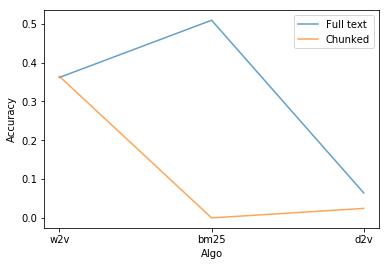

In [62]:
plot_scores([SCORES, SCORES_CHUNKED], ['Full text', 'Chunked'])

Как видно, поиск по разбитым и не разбитым документам показал идентичный уровень качества (BM25 при разбиении не тестировался)<br>
Касательно алгоритмов, наивысшего результата (~0.5) удалось добиться с помощью BM25<br>
Векторные модели показали результат несколько хуже, а `doc2vec` (1000 эпох на лемматизированной коллекции) оказался чрезвычайно плох<br>
В целом решаемая задача кажется трудной, ввиду часто большого размера входящих запросов и неочевидного соответствия между содержанием вопросов и ответов  